# Hugging Face and Sagemaker: fine-tuning DistilBERT with Amazon Polarity dataset

## Introduction

In this demo, you will use the Hugging Faces `transformers` and `datasets` library with Amazon SageMaker to fine-tune a pre-trained transformer on text classification. We will aim to solve chinese document classification task. 
You will then deploy the resulting model for inference using SageMaker Endpoint.

### The model

We'll be using an [BERT](https://arxiv.org/abs/1810.04805). A pre-trained model for chinese language is available in the [`transformers`](https://huggingface.co/transformers/) library from [Hugging Face](https://huggingface.co/).
The chinese model is developed by [CKIP Lab](https://ckip.iis.sinica.edu.tw/). Source codes are listed here - [ckip-transformer](https://github.com/ckiplab/ckip-transformers). 

### The data

We are using a simplified chinese corpus [taotiao news classification](https://github.com/skdjfla/toutiao-text-classfication-dataset.git) to demonstrate the performance of pretrained model 

## Setup
_This notebook was tested in Amazon SageMaker Studio on a **ml.m5.large** instance with **Python 3 (Data Science)** kernel._

### Dependecies
First, you need to install the dependecies required.

In [ ]:
!pip install -qq "sagemaker>=2.48.0" --upgrade
!pip install -qq torch==1.7.1 --upgrade
!pip install -qq sagemaker-huggingface-inference-toolkit 
!pip install -qq transformers==4.6.1 "datasets[s3]"
!pip install -qq ipywidgets
!pip install -qq watermark 
!pip install -qq "seaborn>=0.11.0"

If you are running this on a SageMaker environment, make sure to reboot the Kernel via the dropdown menu at the top after you've installed the above dependencies.

### Development environment 

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [103]:
import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.debugger import ProfilerConfig, DebuggerHookConfig, Rule, ProfilerRule, rule_configs
import sagemaker.huggingface
from sagemaker.huggingface import HuggingFace
import transformers
from transformers import AutoTokenizer
from datasets import load_dataset


import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from textwrap import wrap

import boto3
import pprint
import time

In [6]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 17, 8

## Set up SageMaker session and bucket

In [104]:
sess = sagemaker.Session()
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

role = sagemaker.get_execution_role()
sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

sagemaker role arn: arn:aws:iam::230755935769:role/SageMakerExecutionRoleMLOps
sagemaker bucket: sagemaker-us-west-2-230755935769
sagemaker session region: us-west-2


# Data preparation

The data preparation is straightforward as you're using the `datasets` library to transform dataframe to huggingface dataset. Note that the label encoding should be consecutive integers starting from 0. After preprocessing, the dataset will be uploaded to our `sagemaker_session_bucket` to be used within our training job.

In [248]:
%%bash 
git clone https://github.com/skdjfla/toutiao-text-classfication-dataset.git 
cp toutiao-text-classfication-dataset/toutiao_cat_data.txt.zip .
unzip toutiao_cat_data.txt.zip 

Archive:  toutiao_cat_data.txt.zip
  inflating: toutiao_cat_data.txt    


Cloning into 'toutiao-text-classfication-dataset'...


In [285]:
raw_file_path = './toutiao_cat_data.txt'
!head -n 10 $raw_file_path

6551700932705387022_!_101_!_news_culture_!_京城最值得你来场文化之旅的博物馆_!_保利集团,马未都,中国科学技术馆,博物馆,新中国
6552368441838272771_!_101_!_news_culture_!_发酵床的垫料种类有哪些？哪种更好？_!_
6552407965343678723_!_101_!_news_culture_!_上联：黄山黄河黄皮肤黄土高原。怎么对下联？_!_
6552332417753940238_!_101_!_news_culture_!_林徽因什么理由拒绝了徐志摩而选择梁思成为终身伴侣？_!_
6552475601595269390_!_101_!_news_culture_!_黄杨木是什么树？_!_
6552387648126714125_!_101_!_news_culture_!_上联：草根登上星光道，怎么对下联？_!_
6552271725814350087_!_101_!_news_culture_!_什么是超写实绘画？_!_
6552452982015787268_!_101_!_news_culture_!_松涛听雨莺婉转，下联？_!_
6552400379030536455_!_101_!_news_culture_!_上联：老子骑牛读书，下联怎么对？_!_
6552339283632455939_!_101_!_news_culture_!_上联：山水醉人何须酒。如何对下联？_!_


In [ ]:
!wc -l $raw_file_path

In [259]:
jsonl_file_path = './toutiao_jsonl.json'
file = open(raw_file_path, 'r')
wfile = open(jsonl_file_path, 'w')
labels = [] 
label_names = [] 
sentences = [] 
for l in file.readlines():
    toks = l.split('_!_')
    labels.append(toks[1])
    label_names.append(toks[2])
    sentences.append(toks[3])

from sklearn.preprocessing import LabelEncoder
    
le = LabelEncoder()
le.fit(labels)
enlabels = le.transform(labels)    

text_df = pd.DataFrame({"label":labels, "label_names":label_names, "sentences":sentences, "ohlabels":enlabels})
text_df.head()    

,label,label_names,sentences,ohlabels
0,101,news_culture,京城最值得你来场文化之旅的博物馆,1
1,101,news_culture,发酵床的垫料种类有哪些？哪种更好？,1
2,101,news_culture,上联：黄山黄河黄皮肤黄土高原。怎么对下联？,1
3,101,news_culture,林徽因什么理由拒绝了徐志摩而选择梁思成为终身伴侣？,1
4,101,news_culture,黄杨木是什么树？,1


In [262]:
from sklearn.model_selection import train_test_split


data_df = text_df.drop(['label', 'label_names'], axis=1)
data_df = data_df.rename(columns={"ohlabels":"labels"})

train, test = train_test_split(data_df, test_size=0.2)


In [267]:
from datasets import Dataset


train_dataset = Dataset.from_pandas(train.reset_index())
test_dataset = Dataset.from_pandas(test.reset_index())


In [268]:
print(train_dataset.column_names)

['index', 'sentences', 'labels']


Let's have a look at en example from the training dataset. This allows us to understand what is the format that is expected by Hugging Face Transformers library for input.

In [109]:
train_dataset[0]

{'sentences': '又一款SUV要火，5.4秒破百，2.0T就有300马力，买途观后悔了！', 'labels': 1}

We can also observe the distribution of labels 

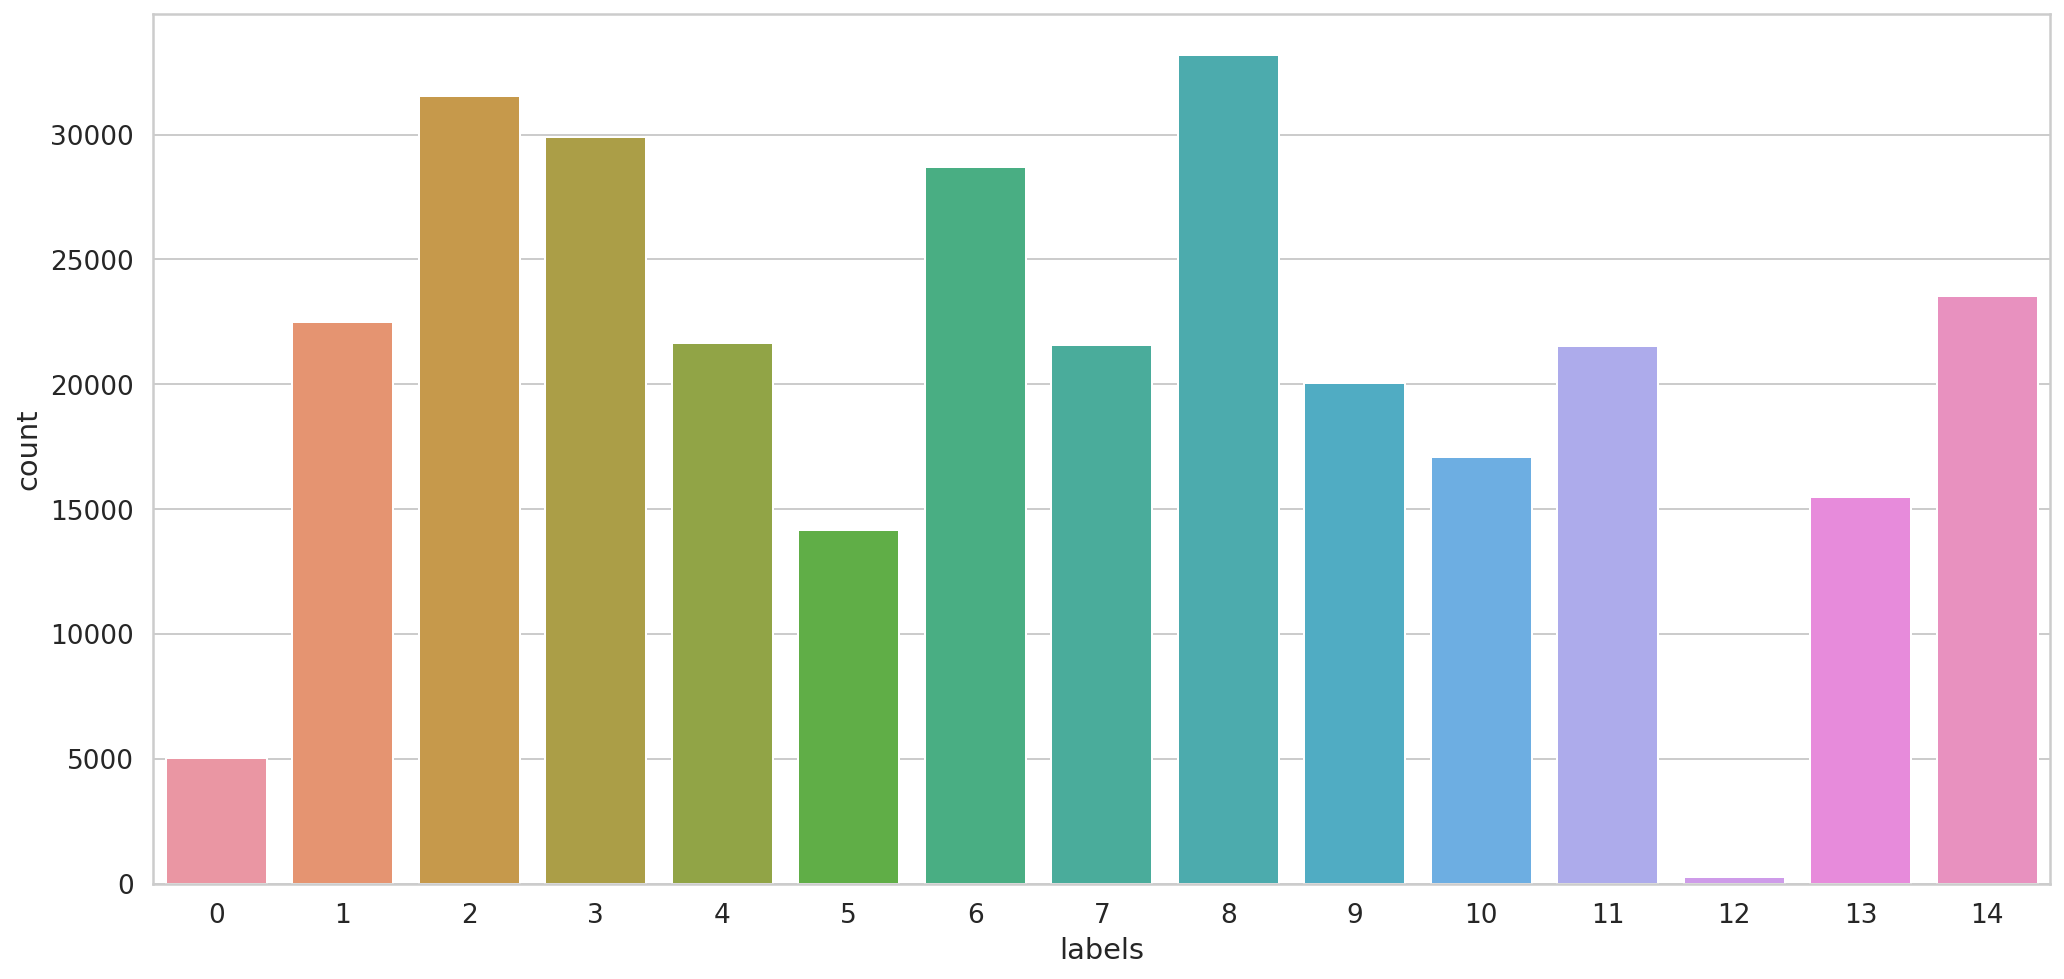

In [269]:
sns.countplot(x=train_dataset['labels'])
plt.xlabel('labels');

## Preparing the dataset to be used with PyTorch
You now need to convert the dataset for training. This means using a tokenizer and getting the PyTorch tensors. Hugging Face provides an [`AutoTokenizer`](https://huggingface.co/transformers/model_doc/auto.html#autotokenizer)

This downloads the tokenizer:

In [270]:
from transformers import BertTokenizerFast

tokenizer_name = 'bert-base-chinese'
tokenizer = BertTokenizerFast.from_pretrained(tokenizer_name)

And this tokenize our training and testing datasets and then set them to the PyTorch format:

In [271]:
# Helper function to get the content to tokenize
def tokenize(batch):
    return tokenizer(batch['sentences'], padding='max_length', truncation=True)

# Tokenize
train_dataset = train_dataset.map(tokenize, batched=True, batch_size=len(train_dataset))
test_dataset = test_dataset.map(tokenize, batched=True, batch_size=len(test_dataset))

# Set the format to PyTorch

train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

## Uploading the data to S3

Now that the data as been processed you can upload it to S3 for training

In [272]:
train_dataset[10]

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0

In [274]:
import botocore
from datasets.filesystems import S3FileSystem

# Upload to S3
dataset_name = "chinese_news"
s3 = S3FileSystem()
s3_prefix = f'samples/datasets/{dataset_name}'
training_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/train'
train_dataset.save_to_disk(training_input_path,fs=s3)
test_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/test'
test_dataset.save_to_disk(test_input_path,fs=s3)

print(f'Uploaded training data to {training_input_path}')
print(f'Uploaded testing data to {test_input_path}')

Uploaded training data to s3://sagemaker-us-west-2-230755935769/samples/datasets/chinese_news/train
Uploaded testing data to s3://sagemaker-us-west-2-230755935769/samples/datasets/chinese_news/test


# Fine-tuning & starting Sagemaker Training Job

In order to create a sagemaker training job you need an `HuggingFace` Estimator. The Estimator handles end-to-end Amazon SageMaker training and deployment tasks. In a Estimator you define, which fine-tuning script should be used as `entry_point`, which `instance_type` should be used, which `hyperparameters` are passed in.
```python
huggingface_estimator = HuggingFace(entry_point='train.py',
                            source_dir='./scripts',
                            instance_type='ml.p3.8xlarge',
                            instance_count=1,
                            role=role,
                            transformers_version='4.6',
                            pytorch_version='1.7',
                            py_version='py36',
                            hyperparameters = hyperparameters)
```
When you create a SageMaker training job, SageMaker takes care of starting and managing all the required compute instances with the `huggingface` container, uploads the provided fine-tuning script `train.py` and downloads the data from our `sagemaker_session_bucket` into the container local storage at `/opt/ml/input/data`. Then, it starts the training job by running. 
```python
/opt/conda/bin/python train.py --epochs 5 --model_name distilbert-base-cased --token_name distilbert-base-cased --train_batch_size 32
```

The `hyperparameters` you define in the `HuggingFace` estimator are passed in as named arguments. The training script expect the `HuggingFace` model and token name so it can retrieve them.

Sagemaker is providing other useful properties about the training environment through various environment variables, including the following:

* `SM_MODEL_DIR`: A string that represents the path where the training job writes the model artifacts to. After training, artifacts in this directory are uploaded to S3 for model hosting.

* `SM_NUM_GPUS`: An integer representing the number of GPUs available to the host.

* `SM_CHANNEL_XXXX:` A string that represents the path to the directory that contains the input data for the specified channel. For example, if you specify two input channels in the HuggingFace estimator’s fit call, named `train` and `test`, the environment variables `SM_CHANNEL_TRAIN` and `SM_CHANNEL_TEST` are set.

You can inspect the training script by running the next cell

In [ ]:
!pygmentize ./scripts/train.py

## Creating an Estimator and start a training job

Name your training job so you can follow it:

In [276]:
model_name = 'bert-base-chinese'
import datetime
ct = datetime.datetime.now() 
current_time = str(ct.now()).replace(":", "-").replace(" ", "-")[:19]
training_job_name=f'finetune-{model_name}-{current_time}'
print( training_job_name )

finetune-bert-base-chinese-2021-09-20-02-32-06


In [277]:
hyperparameters={'epochs': 20,
                 'train_batch_size': 16,
                 'model_name': model_name,
                 'tokenizer_name': tokenizer_name,
                 'output_dir':'/opt/ml/checkpoints',
                 }

In [278]:
metric_definitions=[
    {'Name': 'loss', 'Regex': "'loss': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'learning_rate', 'Regex': "'learning_rate': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_loss', 'Regex': "'eval_loss': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_accuracy', 'Regex': "'eval_accuracy': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_f1', 'Regex': "'eval_f1': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_precision', 'Regex': "'eval_precision': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_recall', 'Regex': "'eval_recall': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_runtime', 'Regex': "'eval_runtime': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_samples_per_second', 'Regex': "'eval_samples_per_second': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'epoch', 'Regex': "'epoch': ([0-9]+(.|e\-)[0-9]+),?"}]

In [279]:
huggingface_estimator = HuggingFace(entry_point='train.py',
                            source_dir='./scripts',
                            instance_type='ml.p3.8xlarge',
                            instance_count=1,
                            role=role,
                            transformers_version='4.6.1', 
                            pytorch_version='1.7.1',
                            py_version='py36',
                            volume_size=100,
                            hyperparameters = hyperparameters,
                            metric_definitions=metric_definitions,
                            max_run=36000, # expected max run in seconds
                        )

Starts the training job using the estimator fit function:

In [280]:
huggingface_estimator.fit({'train': training_input_path, 'test': test_input_path}, wait=False, job_name=training_job_name )

Wait for the training to finish. Training takes approximately 10 mins to complete.

In [281]:
sess.wait_for_job(training_job_name)


2021-09-20 02:32:16 Starting - Starting the training job
2021-09-20 02:32:17 Starting - Launching requested ML instances................
2021-09-20 02:33:43 Starting - Preparing the instances for training.................
2021-09-20 02:35:17 Downloading - Downloading input data......
2021-09-20 02:35:50 Training - Downloading the training image............................
2021-09-20 02:38:16 Training - Training image download completed. Training in progress...................................................................................................................................................................................................................................................................................

KeyboardInterrupt: 

## Training metrics
You can now display the training metrics

In [ ]:
from sagemaker import TrainingJobAnalytics

# Captured metrics can be accessed as a Pandas dataframe
df = TrainingJobAnalytics(training_job_name=training_job_name).dataframe()
df.head(10)

And plot the collected metrics

In [ ]:
evals = df[df.metric_name.isin(['eval_accuracy','eval_precision', 'eval_f1'])]
losses = df[df.metric_name.isin(['loss', 'eval_loss'])]

sns.lineplot(
    x='timestamp', 
    y='value', 
    data=evals, 
    style='metric_name',
    markers=True,
    hue='metric_name'
)

ax2 = plt.twinx()
sns.lineplot(
    x='timestamp', 
    y='value', 
    data=losses, 
    hue='metric_name',
    ax=ax2)

# Endpoint

The `transformers pipelines` API allows you to use the `pipelines` features. 
Your inputs need to be defined in the `inputs` key.
If you want additional supported `pipelines` parameters you can add them in the `parameters` key.
The API is oriented at the API of the [🤗  Accelerated Inference API](https://api-inference.huggingface.co/docs/python/html/detailed_parameters.html), meaning your inputs need to be defined in the `inputs` key and if you want additional supported `pipelines` parameters you can add them in the `parameters` key. 

Below are a few request examples:

**text-classification request body**

```python
{
    "inputs": "Camera - You are awarded a SiPix Digital Camera! call 09061221066 fromm landline. Delivery within 28 days."
}
```

**question-answering request body**

```python
{
    "inputs": {
        "question": "What is used for inference?",
        "context": "My Name is Philipp and I live in Nuremberg. This model is used with sagemaker for inference."
    }
}
```

**zero-shot classification request body**

```python
{
    "inputs": "Hi, I recently bought a device from your company but it is not working as advertised and I would like to get reimbursed!\",
    "parameters": {
        "candidate_labels": [
            "refund",
            "legal",
            "faq"
         ]
    }
}
```

You can now proceed and create an endpoint with the trained model.

In [ ]:
predictor = huggingface_estimator.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge", endpoint_name=training_job_name)

After the endpoint is deployed you can run a prediction. `LABEL_0` indicates a negative review, `LABEL_1` indicates a positive review, and score corresponds to the probability of each label.

In [203]:
data = {
   "inputs": [
       "京城最值得你来场文化之旅的博物馆",
       "Product is not good at all",
       "Idea is good, but product quality is poor"
   ]
}

# request
predictor.predict(data)

[{'label': 'LABEL_4', 'score': 0.06717121601104736},
 {'label': 'LABEL_6', 'score': 0.06807070970535278},
 {'label': 'LABEL_6', 'score': 0.06825195997953415}]

# Cleanup
After you are finished experimenting with this notebook, run the following cell to delete the predictor.

In [ ]:
predictor.delete_endpoint()